# Clustering and Segmentation

In this assignment we are going to divide the customers into various segments based on their spending habits, tenure with the company etc and then we will be defining a strategy to target them. Two approaches-Heuristic and K-means will be used.

In [93]:
#loading the required packages

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.impute import SimpleImputer

In [76]:
# Load the datasets
online_sales = pd.read_csv('C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Projects\\Marketing insights\\Online_Sales.csv')
customer_data = pd.read_excel('C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Projects\\Marketing insights\\CustomersData.xlsx')
discount_coupons = pd.read_csv('C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Projects\\Marketing insights\\Discount_Coupon.csv')
marketing_spend= pd.read_csv('C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Projects\\Marketing insights\\Marketing_Spend.csv')
tax_amount = pd.read_excel('C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Projects\\Marketing insights\\Tax_amount.xlsx')

In [77]:
# Merging datasets using 'CustomerID' and 'Product Category as the common key
merged_data = pd.merge(online_sales, customer_data, on='CustomerID', how='left')
merged_data = pd.merge(merged_data, discount_coupons, on='Product_Category', how='left')
merged_data = pd.merge(merged_data, tax_amount, on='Product_Category', how='left')


In [78]:
# Convert 'Date' column in the marketing_spend DataFrame to datetime data type
marketing_spend['Date'] = pd.to_datetime(marketing_spend['Date'])
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'], format='%Y%m%d')

# Merge datasets using 'Transaction_Date' as the common key
merged_data = pd.merge(merged_data, marketing_spend, left_on='Transaction_Date', right_on='Date', how='left')


# Dropping the duplicate 'Date' column if needed
merged_data.drop(columns=['Date'], inplace=True)


In [79]:
#examining the merged dataset
merged_data.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_name,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Gender,Location,Tenure_Months,Month,Coupon_Code,Discount_pct,GST,Offline_Spend,Online_Spend,Total
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,Jan,ELEC10,10.0,0.1,4500,2424.5,6924.5
1,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,Feb,ELEC20,20.0,0.1,4500,2424.5,6924.5
2,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,Mar,ELEC30,30.0,0.1,4500,2424.5,6924.5
3,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,Apr,ELEC10,10.0,0.1,4500,2424.5,6924.5
4,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,M,Chicago,12,May,ELEC20,20.0,0.1,4500,2424.5,6924.5


In [80]:
# Calculating Invoice Value for each transaction in the merged dataset
merged_data['Invoice_Value'] = (
    (merged_data['Quantity'] * merged_data['Avg_Price']) *
    (1 - merged_data['Discount_pct']) *
    (1 + merged_data['GST']) +
    merged_data['Delivery_Charges']
).abs()

merged_data['Invoice_Value']

0          1515.229
1          3206.039
2          4896.849
3          1515.229
4          3206.039
            ...    
630683     6711.482
630684    10254.362
630685     3168.602
630686     6711.482
630687    10254.362
Name: Invoice_Value, Length: 630688, dtype: float64

In [81]:
# correcting 'Transaction_Date' column


merged_data['Transaction_Date'] = merged_data['Transaction_Date'].dt.strftime('%d-%m-%Y')


print(merged_data[['Transaction_Date']].head())

  Transaction_Date
0       01-01-2019
1       01-01-2019
2       01-01-2019
3       01-01-2019
4       01-01-2019


In [82]:
#renaming column 
merged_data['totalmarketingspend'] =merged_data['Total']
merged_data['totalmarketingspend']


0         6924.50
1         6924.50
2         6924.50
3         6924.50
4         6924.50
           ...   
630683    6058.75
630684    6058.75
630685    6058.75
630686    6058.75
630687    6058.75
Name: totalmarketingspend, Length: 630688, dtype: float64

In [83]:
#Dropping redundant columns
merged_data=merged_data.drop(['Offline_Spend','Online_Spend','Total','Month','Discount_pct','GST','Delivery_Charges','Quantity','Avg_Price','Product_SKU','Coupon_Status','Product_name','Product_Category','Coupon_Code'],axis=1)
merged_data.head()



,CustomerID,Transaction_ID,Transaction_Date,Gender,Location,Tenure_Months,Invoice_Value,totalmarketingspend
0,17850,16679,01-01-2019,M,Chicago,12,1515.229,6924.5
1,17850,16679,01-01-2019,M,Chicago,12,3206.039,6924.5
2,17850,16679,01-01-2019,M,Chicago,12,4896.849,6924.5
3,17850,16679,01-01-2019,M,Chicago,12,1515.229,6924.5
4,17850,16679,01-01-2019,M,Chicago,12,3206.039,6924.5


In [84]:
# converting 'Transaction_Date' to datetime
merged_data['Transaction_Date'] = pd.to_datetime(merged_data['Transaction_Date'])
merged_data['Transaction_Date']

C:\Users\sujoydutta\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sujoydutta\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sujoydutta\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15-01-2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sujoydutta\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16-01-2019' in DD/MM/YYYY format. Prov

0        2019-01-01
1        2019-01-01
2        2019-01-01
3        2019-01-01
4        2019-01-01
            ...    
630683   2019-12-31
630684   2019-12-31
630685   2019-12-31
630686   2019-12-31
630687   2019-12-31
Name: Transaction_Date, Length: 630688, dtype: datetime64[ns]

**Part 1: Heuristic(Value-Based) Segmentation**

This is the first type of segmentation we are going to apply to categorize customers into 4 categories:Standard,Silver,Gold and Platinum based on RFM(Recency, Frequency, Monetary) criterion. 

In [27]:
# Calculating today's date
today_date = merged_data['Transaction_Date'].max()

# Calculating Recency, Frequency, and Monetary metrics
rfm_data = merged_data.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (today_date - x.max()).days,  # Recency
    'Transaction_ID': 'nunique',  # Frequency
    'Invoice_Value': 'sum'  # Sum of Invoice_Value
}).reset_index()


In [29]:
# Renaming the columns for clarity
rfm_data.rename(columns={
    'Transaction_Date': 'Recency',
    'Transaction_ID': 'Frequency',
    'Invoice_Value': 'Monetary'
}, inplace=True)
rfm_data.round()

,CustomerID,Recency,Frequency,Monetary
0,12346,107,1,6337.0
1,12347,282,31,3612323.0
2,12348,73,8,372859.0
3,12350,17,11,342366.0
4,12356,107,13,355835.0
...,...,...,...,...
1463,18259,241,3,127793.0
1464,18260,53,19,582011.0
1465,18269,194,2,26648.0
1466,18277,69,1,74666.0


In [30]:
# Calculating RFM scores by ranking customers
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], q=4, labels=False)
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'], q=4, labels=False)
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], q=4, labels=False)


In [31]:
# Calculating the overall RFM score
rfm_data['RFM_Score'] = rfm_data['R_Score'] + rfm_data['F_Score'] + rfm_data['M_Score']


In [32]:
# Defining segmentation criteria based on RFM scores
segmentation_criteria = {
    'Premium': (3, 3, 3),  # High R, High F, High M
    'Gold': (3, 2, 2),     # High R, Mid F, Mid M
    'Silver': (2, 2, 2),   # Mid R, Mid F, Mid M
    'Standard': (0, 0, 0)  # Low R, Low F, Low M
}


In [33]:
# Creating a function to assign segments based on criteria
def assign_segment(row):
    for segment, criteria in segmentation_criteria.items():
        if all(row[['R_Score', 'F_Score', 'M_Score']] >= criteria):
            return segment
    return 'Other'

In [34]:
# Applying the segmentation function to each customer
rfm_data['Segment'] = rfm_data.apply(assign_segment, axis=1)


In [35]:
# Counting the number of customers in each segment
segment_counts = rfm_data['Segment'].value_counts()
segment_counts

Standard    1215
Silver       134
Gold          68
Premium       51
Name: Segment, dtype: int64

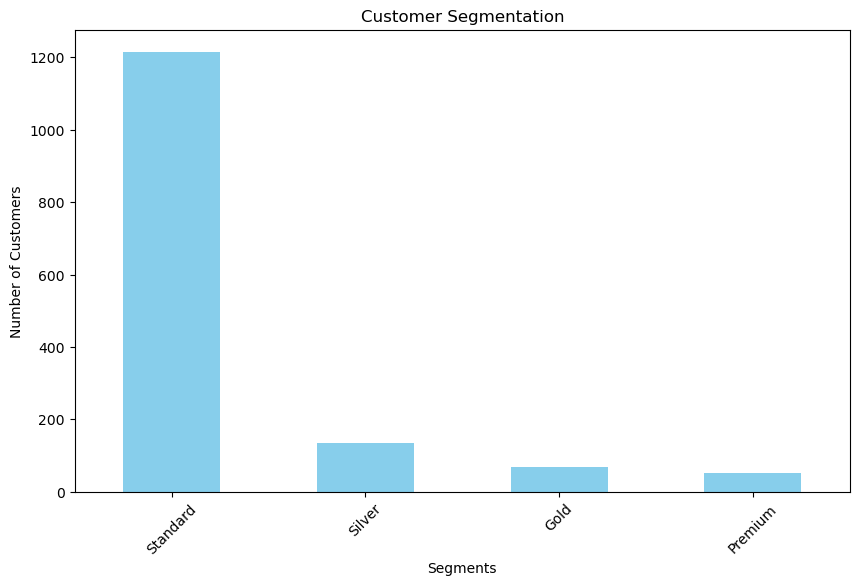

In [36]:
# Creating a bar plot to visualize the distribution of segments
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar', color='skyblue')
plt.title('Customer Segmentation')
plt.xlabel('Segments')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

**Strategy for each segment**

**'Premium':** We must focus on retaining these high-value customers with personalized offers and excellent service. Encourage them to refer friends and family and give them discounts in return.

**'Gold':** TWe must come out with incentives for increased spending and engagement. It is a must to offer them loyalty rewards to maintain their loyalty.

**'Silver':** we must keep these customers engaged by sending them regular promotions and updates. We must encourage them to upgrade to higher segments.

**'Standard':** Target these customers with promotions to increase their spending and engagement. Focus on converting them into higher segments.


**Part 2: K-means(Scientific) Segmentation**

This is the second type of segmentation we are going to apply to categorize customers into optimal number of clusters.The numeric variables will be scaled and compressed to Principal components and then clusters would be made on the basis of euclidean distance between points. 

In [85]:
# Calculating days since last transaction
max_date = merged_data['Transaction_Date'].max()
merged_data['Recency'] = (max_date - merged_data['Transaction_Date']).dt.days
merged_data['Recency']

0         364
1         364
2         364
3         364
4         364
         ... 
630683      0
630684      0
630685      0
630686      0
630687      0
Name: Recency, Length: 630688, dtype: int64

In [86]:
# Dropping the unnecesary columns
merged_data=merged_data.drop(['Transaction_Date','CustomerID','Transaction_ID'], axis=1)

merged_data

,Gender,Location,Tenure_Months,Invoice_Value,totalmarketingspend,Recency
0,M,Chicago,12,1515.229,6924.50,364
1,M,Chicago,12,3206.039,6924.50,364
2,M,Chicago,12,4896.849,6924.50,364
3,M,Chicago,12,1515.229,6924.50,364
4,M,Chicago,12,3206.039,6924.50,364
...,...,...,...,...,...,...
630683,F,California,7,6711.482,6058.75,0
630684,F,California,7,10254.362,6058.75,0
630685,F,California,7,3168.602,6058.75,0
630686,F,California,7,6711.482,6058.75,0


In [88]:
# Perform one-hot encoding
merged_data = pd.get_dummies(merged_data, columns=['Gender', 'Location'])
merged_data

,Tenure_Months,Invoice_Value,totalmarketingspend,Recency,Gender_F,Gender_M,Location_California,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC
0,12,1515.229,6924.50,364,0,1,0,1,0,0,0
1,12,3206.039,6924.50,364,0,1,0,1,0,0,0
2,12,4896.849,6924.50,364,0,1,0,1,0,0,0
3,12,1515.229,6924.50,364,0,1,0,1,0,0,0
4,12,3206.039,6924.50,364,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
630683,7,6711.482,6058.75,0,1,0,1,0,0,0,0
630684,7,10254.362,6058.75,0,1,0,1,0,0,0,0
630685,7,3168.602,6058.75,0,1,0,1,0,0,0,0
630686,7,6711.482,6058.75,0,1,0,1,0,0,0,0


In [145]:
# Standardizing the data 
scaler = StandardScaler()
merged_data_scaled = scaler.fit_transform(merged_data)
merged_data_scaled

array([[-1.04939813, -0.08891677,  1.54086686, ..., -0.51753946,
        -0.23320675, -0.77371162],
       [-1.04939813,  0.35434271,  1.54086686, ..., -0.51753946,
        -0.23320675, -0.77371162],
       [-1.04939813,  0.79760219,  1.54086686, ..., -0.51753946,
        -0.23320675, -0.77371162],
       ...,
       [-1.42048942,  0.3445283 ,  0.93396959, ..., -0.51753946,
        -0.23320675,  1.7131431 ],
       [-1.42048942,  1.27332287,  0.93396959, ..., -0.51753946,
        -0.23320675,  1.7131431 ],
       [-1.42048942,  2.20211744,  0.93396959, ..., -0.51753946,
        -0.23320675,  1.7131431 ]])

In [146]:
# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your data
merged_data_scaled = imputer.fit_transform(merged_data_scaled)
merged_data_scaled

array([[-1.04939813, -0.08891677,  1.54086686, ..., -0.51753946,
        -0.23320675, -0.77371162],
       [-1.04939813,  0.35434271,  1.54086686, ..., -0.51753946,
        -0.23320675, -0.77371162],
       [-1.04939813,  0.79760219,  1.54086686, ..., -0.51753946,
        -0.23320675, -0.77371162],
       ...,
       [-1.42048942,  0.3445283 ,  0.93396959, ..., -0.51753946,
        -0.23320675,  1.7131431 ],
       [-1.42048942,  1.27332287,  0.93396959, ..., -0.51753946,
        -0.23320675,  1.7131431 ],
       [-1.42048942,  2.20211744,  0.93396959, ..., -0.51753946,
        -0.23320675,  1.7131431 ]])

In [149]:
# Determining the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(merged_data_scaled)
    wcss.append(kmeans.inertia_)


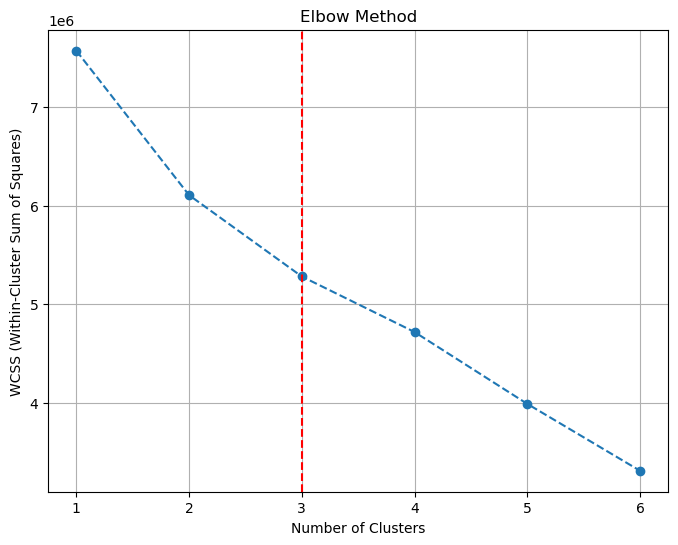

In [150]:
# Plotting the optimal clusters graph


plt.figure(figsize=(8, 6))
plt.plot(range(1, 7), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')

diff = [wcss[i] - wcss[i - 1] for i in range(1, len(wcss))]
optimal_num_clusters = diff.index(max(diff)) + 1


plt.axvline(x=optimal_num_clusters, color='red', linestyle='--')

plt.grid()
plt.show()

In [151]:
# Finding the "elbow" point by looking for the steepest slope
diff = [wcss[i] - wcss[i - 1] for i in range(1, len(wcss))]
optimal_num_clusters = diff.index(max(diff)) + 1
optimal_num_clusters

3

In [152]:
# Plotting the K-Means clustering results with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_num_clusters, init='k-means++', random_state=42)
kmeans_optimal.fit(merged_data_scaled)
labels = kmeans_optimal.labels_


In [153]:
# Based on the Elbow method the optimal number has been set
optimal_clusters = 3

# Performing K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
merged_data['Cluster'] = kmeans.fit_predict(merged_data_scaled)


In [157]:
# Viewing the cluster centers
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=merged_data.columns  
)
print(cluster_centers)

   Tenure_Months  Invoice_Value  totalmarketingspend     Recency  \
0      25.949355    1794.781643          4703.756100  175.987027   
1      26.878421    1863.326859          4663.678146  184.980189   
2      25.191622    1955.536061          4883.087213  179.271255   

       Gender_F      Gender_M  Location_California  Location_Chicago  \
0  1.000000e+00  4.040657e-13        -7.494005e-14      5.250251e-01   
1 -6.936673e-13  1.000000e+00         3.141365e-01      3.462553e-01   
2  1.000000e+00  1.809664e-13         8.866331e-01      1.394440e-13   

   Location_New Jersey  Location_New York  Location_Washington DC   Cluster  
0         1.400778e-01       3.348971e-01           -3.868433e-14  1.719844  
1         7.230952e-02       1.936108e-01            7.368785e-02  1.075066  
2        -4.850287e-14       1.239009e-13            1.133669e-01  3.886633  


In [158]:
# Analyzing the results
cluster_counts = merged_data['Cluster'].value_counts().sort_index()
print(cluster_counts)


0    260698
1    237244
2    132746
Name: Cluster, dtype: int64


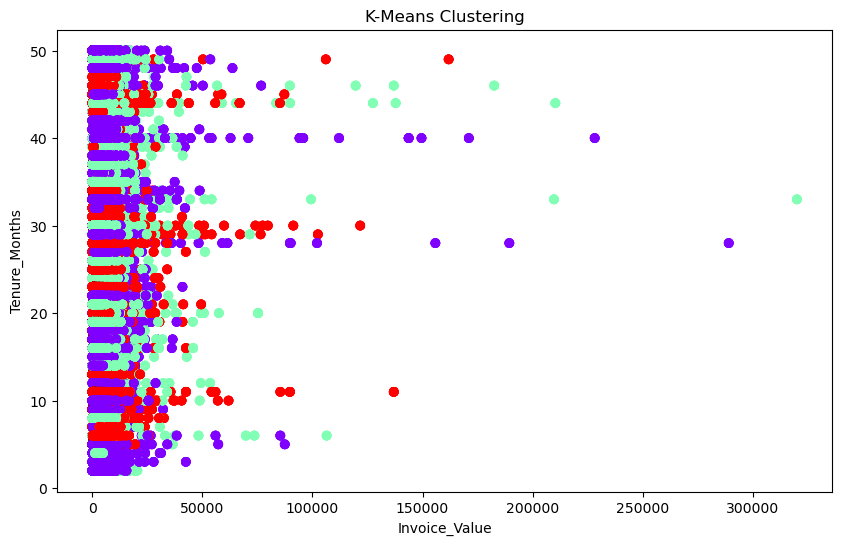

In [159]:
# Visualizing the clusters 
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Invoice_Value'], merged_data['Tenure_Months'], c=merged_data['Cluster'], cmap='rainbow')
plt.title('K-Means Clustering')
plt.xlabel('Invoice_Value')
plt.ylabel('Tenure_Months')
plt.show()

*Remark:After performing k-means clustering we can conclude that the three clusters overlap one another and there is not sufficient difference between the three groups and hence heuristic clustering worked better in this case.*